In [2]:
from pylab import *
import random_idx
from __future__ import division
import scipy
import time

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})


height has been deprecated.

2016-12-14 12:31


In [3]:
import scipy
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_decay(M,ll=1, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))
    
    dM = (1 / (1 - ll**2))
    
    for iM,Mval in enumerate(M):
        avals = np.linspace(N * ll ** Mval - 8 * (N*dM)**0.5, N * ll ** Mval + 8 * (N*dM)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N * ll ** Mval) / ((dM)*N)**0.5) - ncdf((avals[:-1]-N * ll ** Mval) / ((dM)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(dM*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [4]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_l(M, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [5]:
def fhrr_vec(D, N):
    # pick a random phase
    rphase = 2 * np.pi * np.random.rand(D, N // 2)

    fhrrv = np.zeros((D, 2 * (N//2)))
    fhrrv[:, :(N//2)] = np.cos(rphase)
    fhrrv[:, (N//2):] = np.sin(rphase)
    
    return fhrrv

def fhrr_inv(a):
    N2 = a.shape[1] // 2
    b = np.zeros_like(a)
    b[:,:N2] = a[:, :N2]
    b[:,N2:] = -a[:, N2:]
    
    return b

def fhrr_bind(a, b):
    # we want to do element wise multiply of complex numbers
    N2 = a.shape[1] // 2
    
    ra = a[:, :N2]
    ia = a[:, N2:]
    rb = b[:, :N2]
    ib = b[:, N2:]
    
    c = np.zeros_like(a)
    
    c[:, :N2] = ra * rb - ia * ib
    c[:, N2:] = ra * ib + rb * ia
    
    return c
    
def fhrr_roll(a, r=1):
    N2 = a.shape[1] // 2
    c = np.zeros_like(a)
    c[:, :N2] = np.roll(a[:, :N2], r, axis=1)
    c[:, N2:] = np.roll(a[:, N2:], r, axis=1)
    
    return c

In [7]:
N=10000
D=32
sf = 0.5

letter_vectors = fhrr_vec(D, N)
# @todo: N has to be even

bind_vec = fhrr_vec(1, N)


# sparsity is just replacing +1/-1 with zero randomly
make_sparse = np.random.rand(D,N/2) < sf
make_sparse = np.hstack((make_sparse, make_sparse))

letter_vectors[make_sparse] = 0


key_sparse = np.random.rand(1,N/2) < sf
key_sparse = np.hstack((key_sparse, key_sparse))

bind_vec[key_sparse] = 0
    

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


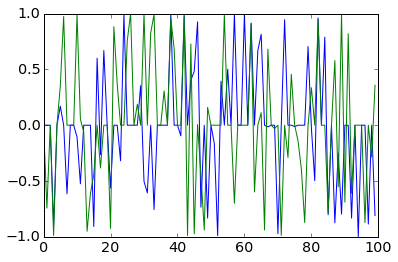

In [10]:
plot(letter_vectors[2, 200:300])
plot(bind_vec[0, 200:300])

## Sparsity

The first way we are going to test sparsity is by defining a "sparsity factor", which is simply the probability that one of the elements of the basis vectors is replaced by 0. We will then adjust this sparsity factor and then compute the capacity using the letter sequence task.

In [5]:
def test_capacity_sparsity(N, D, K=5, sf=0.1, trials=5e3):
    '''
    Runs a capacity experiment with sparsity in the basis vectors
    '''
    # @todo: N has to be even
    
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1
    
    # sparsity is just replacing +1/-1 with zero randomly
    make_sparse = np.random.rand(D,N/2) < sf
    
    make_sparse = np.hstack((make_sparse, make_sparse))
    
    letter_vectors[make_sparse] = 0
    
    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)
    
    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)
        
        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))

        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [20]:
def test_capacity_fhrr_bind_sf(N, D, K=5, sf=0.1, trials=5e3):
    letter_vectors = fhrr_vec(D, N)
    # @todo: N has to be even

    bind_vec = fhrr_vec(1, N)
    
    
    # sparsity is just replacing +1/-1 with zero randomly
    make_sparse = np.random.rand(D,N/2) < sf
    make_sparse = np.hstack((make_sparse, make_sparse))
    
    letter_vectors[make_sparse] = 0
    
    
    key_sparse = np.random.rand(1,N/2) < sf
    key_sparse = np.hstack((key_sparse, key_sparse))
    # if you make the key sparse, then it is like decay
    #bind_vec[key_sparse] = 0
    

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    
    hypercapacity = fhrr_bind(bind_vec, letter_vectors[lidx[0]:(lidx[0]+1), :])

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        lidx[i+1] = np.random.randint(D)
        
        lv = letter_vectors[lidx[i+1]:(lidx[i+1]+1), :]
        
        #bind_vec = fhrr_roll(bind_vec)
        #hypercapacity += fhrr_bind(bind_vec, lv)
        hypercapacity = fhrr_bind(bind_vec, hypercapacity) + lv
        
        v_last_input = fhrr_bind(fhrr_inv(bind_vec), hypercapacity)
        v_input_K = fhrr_bind(fhrr_inv(fhrr_roll(bind_vec, -K)), hypercapacity)
        v_first_input = fhrr_bind(fhrr_inv(fhrr_roll(bind_vec, -(i+1))), hypercapacity)
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

[[ 0  0  0 ...,  0 -1  0]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., -1  1  1]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0 -1  0]]


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-pac

Duration:  8.85239505768


(array([ 12.,  11.,   3., ...,   3.,  23.,   1.]),
 array([ 12.,  11.,   3., ...,   3.,  23.,   0.]),
 array([ 12.,  19.,  14., ...,   1.,  21.,   0.]),
 array([ 12.,  12.,  12., ...,  12.,  12.,   0.]))

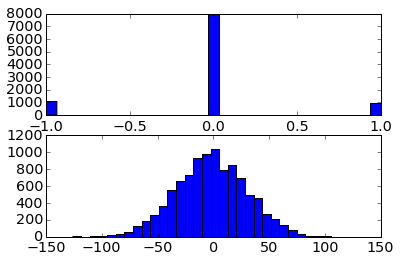

In [57]:
def test_capacity_sparsity_plot(N, D, K=5, sf=0.1, trials=5e3):
    '''
    Runs a capacity experiment with sparsity in the basis vectors
    '''
    
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1
    
    # sparsity is just replacing +1/-1 with zero randomly
    make_sparse = np.random.rand(D,N) < sf 
    letter_vectors[make_sparse] = 0
    
    print letter_vectors
    
    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity += letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)
    
    subplot(211)
    hist(hypercapacity, 31)
    #plot(hypercapacity)
    #print hypercapacity
    
    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)
        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))

        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    subplot(212)
    hist(hypercapacity, 31)
    #plot(hypercapacity)
    #print hypercapacity
    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

test_capacity_sparsity_plot(10000, 27, K=5, sf=0.8)

**Figure: Distribution of hypervector elements:** With sparse basis functions, many of the items are 0. Here the sparseness factor is set to 0.80 -- i.e. 80% of elements are set to 0. The sum of many sparse basis vectors, however, leads to their superposition having a gaussian distribution. 

In [21]:
K=5
N = 10000
test_sf = linspace(0.95, 1, 6)

runs = 15

run_id = []
run_sf = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for sf in test_sf:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_sparsity(N, len(random_idx.alphabet), K=K, sf=sf)
        
        run_id.append(r)
        run_sf.append(sf)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/capacity-sf-N=' + str(N) + '-tc=' + str(len(test_sf)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all, K=K,
        run_id=run_id, run_sf=run_sf, runs=runs, N=N, D=len(random_idx.alphabet), test_sf=test_sf)

0


NameError: name 'test_capacity_sparsity' is not defined

In [22]:
K=5
N = 10000
test_sf = linspace(0.1, 1, 6)

runs = 5

run_id = []
run_sf = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for sf in test_sf:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_fhrr_bind_sf(N, len(random_idx.alphabet), K=K, sf=sf)
        
        run_id.append(r)
        run_sf.append(sf)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/capacity-unit_key-sf-N=' + str(N) + '-tc=' + str(len(test_sf)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all, K=K,
        run_id=run_id, run_sf=run_sf, runs=runs, N=N, D=len(random_idx.alphabet), test_sf=test_sf)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-pack

Duration:  2.84194397926
Duration:  3.25744700432
Duration:  3.04842114449
Duration:  2.74361801147
Duration:  2.79796099663
Duration:  2.76093792915
1
Duration:  3.25634098053
Duration:  3.34292197227
Duration:  2.89331817627
Duration:  2.60088300705
Duration:  2.65428686142
Duration:  2.67843294144
2
Duration:  2.94786405563
Duration:  2.80092287064
Duration:  3.01694297791
Duration:  3.24236083031
Duration:  2.65865683556
Duration:  3.045140028
3
Duration:  3.10188388824
Duration:  2.84407997131
Duration:  3.35592889786
Duration:  3.11078095436
Duration:  2.64390802383
Duration:  3.20710611343
4
Duration:  2.99652600288
Duration:  3.19613909721
Duration:  3.06411504745
Duration:  3.46688699722
Duration:  3.15757107735
Duration:  3.06053113937
data/capacity-unit_key-sf-N=10000-tc=6-r=5-n161214.npz


In [26]:
#h = np.load('data/hypervector_capacity_decay-d=0.998-N=1-D=3-r=5-n160518.npz')
#h = np.load('data/capacity-clip-lookback-N=5000-tc=7-r=15-n160623.npz')
#h = np.load('data/capacity-sf-N=10000-tc=5-r=15-n160827.npz')
h = np.load('data/capacity-sf-N=10000-tc=6-r=15-n160828.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
run_id = h['run_id']
run_sf = h['run_sf']
test_sf = h['test_sf']
runs = h['runs']
N = h['N']
D = h['D']
K = h['K']

In [23]:
run_id = np.array(run_id)
run_sf = np.array(run_sf)

usf = unique(run_sf)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(usf)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(usf)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(usf)))

for idx_sf, sf in enumerate(usf):
    idxs = find(run_sf==sf)
    for i in idxs:
        li_mean[:,idx_sf] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,idx_sf] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,idx_sf] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


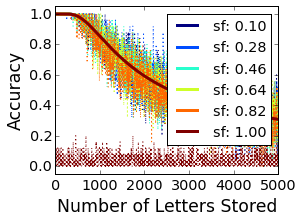

In [24]:
figure(figsize=(4,3))
cm=get_cmap('jet', li_mean.shape[1])

M = np.arange(li_mean.shape[0])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=1)


    plot(M, p_correct_l(M, N=N, D=len(random_idx.alphabet)), 
         color=cm(i), lw=3, label="sf: %0.2f" % test_sf[i])

#for idx_clip, clip in enumerate(test_clip):
#    p_correct = p_correct_l(M, N=N, D=len(random_idx.alphabet))
#    plot(M, p_correct, color=cm(idx_clip),lw=3, label="clip: %3d" % clip)


legend(loc='upper right');
#legend(loc='lower left');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of Letters Stored');
ylabel('Accuracy')
ylim([-0.05, 1.05])
savefig('figures/capacity_sf-unit_key-N=' + str(N) +'-sf=' + str(len(test_sf)) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity_sf-unit_key-N=' + str(N) + '-sf=' + str(len(test_sf)) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

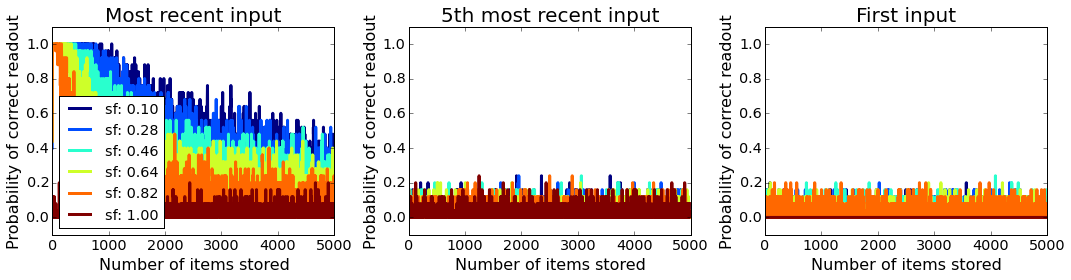

In [19]:
figure(figsize=(15,4))

subplot(131)
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same')[:-smoothN//2], 
         color=cm(i), lw=3, label="sf: %0.2f" % test_sf[i])
    
legend(loc='lower left');
title('Most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
ylim([-0.1, 1.1])

subplot(132)
cm=get_cmap('jet', iK_mean.shape[1])

for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same')[:-22],
         color=cm(i), lw=3, label="sf: %0.2f" % test_sf[i])
    
#legend(loc='lower left');
title('%dth most recent input' % K, fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
ylim([-0.1, 1.1])

subplot(133)
cm=get_cmap('jet', li_mean.shape[1])

for i in range(fi_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(fi_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         color=cm(i), lw=3, label="sf: %0.2f" % test_sf[i])
    
#legend(loc='lower left');
title('First input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
ylim([-0.1, 1.1])
plt.tight_layout()

savefig('figures/capacity-sf-recency-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-sf-recency-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

### Sparsity Derivation

We see that having sparsity essentially has no effect on the capacity of the hypervector, up until the point where there is a catastrophe when all of the +1, -1 are replaced by 0. 

The reason that the capacity isn't really effected is because the sum vector still retains its Gaussian (max entropy) statistics. This is the true thing that limits the information transmitted, and since every type of sparse vector leads to the Gaussian sum, then the total capacity is not different.

We can see that sparsity will effect both the signal and the noise equally, and essentially cancel out to lead to the same capacity result. 

$$
\mathcal{H}_{sf} := (X^{sf}_{\mu_\ell})^T \rho^{-\mu} (\Psi) =
(X^{sf}_{\mu_\ell}) ^T X^{sf}_{\mu_\ell} + \sum_{m \ne \mu}^M (X^{sf}_{\mu_\ell}) ^T \rho^{m-\mu} (X^{sf}_{m_\ell})
$$

So, we need to figure out the signal and noise. The signal is just the dot product of two sparse basis vectors. These will have $N*sf$ $+1$ or $-1$ aligned, which means the dot product will be $N*sf$. 

Now, we must consider the variance of two random sparse basis vectors. If the +1 or -1 is aligned with a 0 in the other sparse vector, then this will have no contribution to the variance. Therefore, only the aligned and non-zero elements will contribute to the variance. This means that each distractor contributes to the variance by $sf^2 N$. This the distribution is given by:

$$
\mathcal{H}_{sf} = N ( N sf, M N sf^2)
$$

From here it can easily be seen that the signal-to-noise ratio of these vectors will be constant, regardless of the sparseness factor:

$$
SNR = \frac{\mu}{\sigma} = \frac{N sf}{\sqrt{M N sf^2}} = \frac{N}{\sqrt{M N}}
$$